## Why Knowledge Graph

#### With text similarity, wide range of selections are possible. With Knowledge Graph, text similarity makes sure that the correct actors are chosen. This ensures that the content is chosen from the correct context.

In [194]:
project_id = "gen-lang-client-0089914856"
location = "us-central1"

In [273]:
# Initialize the Gemini API

from google.auth import default
import google.auth.transport.requests

import openai

# Programmatically get an access token
credentials, _ = default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
credentials.refresh(google.auth.transport.requests.Request())

# OpenAI Client
client = openai.OpenAI(
    base_url=f"https://{location}-aiplatform.googleapis.com/v1/projects/{project_id}/locations/{location}/endpoints/openapi",
    api_key=credentials.token,
)

# print(response)

## What is needed for the Knowledge Graph.
#### -> List of Nodes, List of relationships
##### For each Node, create a separate csv file. Nodes are mainly the actors that knowledge graph is interested about.
##### Each CSV file contains columns that describe the property. :ID and :Label are a must.

In [279]:
# Define the prompt templates

system_prompt = f"""
for the given list of texts, make csv files with an appropriate format so that they can be loaded easily into neo4j based knowledge graph.
Make sure that the columns of the csv file are appropriate for neo4j, such that one can easily import and visualize.
Include :ID, :TYPE and :LABEL in which ever file they are required. Let the id take the integers only.
The texts are book summaries without any information about books, publishers and authors. The list contains only the single liner summary.

In the output, write the file name (example summaries.csv) followed by a new line character and the content of the csv file.
Separate each combination of name of the csv file and the contents of the csv file with a ***.

Do not write anything else. Think about what should be the best way to represent the knowledge graph for this data.

"""

system_prompt_dict = {"role":'system',"content":system_prompt}


def make_user_prompt(texts:list):
    text_space = ""
    for index, text in enumerate(texts):
        text_space += f"Text {index+1}: {text} \n\n"
    
    text_prompt = f"""
    {text_space}

    Output:
    
    """
    user_prompt_dict = {"role":'user', 'content':text_prompt}
    return user_prompt_dict


In [280]:
from pathlib import Path

def return_representation(passages:str):
    response = client.chat.completions.create(
        model="google/gemini-2.0-flash-001",
        messages=[system_prompt_dict, make_user_prompt(passages)]
    )

    response = response.to_dict()['choices'][0]['message']['content']
    return response.strip()

# import data and make batches
path_csv = Path("/Users/akshitbhatia/Downloads/books_summary.csv")
summaries = pd.read_csv(path_csv)['summaries'].to_list()
# batch_size=3

# batches = [summaries[i:i + batch_size] for i in range(0, len(summaries), batch_size)]

In [281]:
# create fresh knowledge graphs

import time
# responses = []
# for batch in batches[:2]: # 30 books (batch of 15 each)
responses = return_representation(summaries[:20])


In [282]:
responses

'books.csv\n:ID,:TYPE,:LABEL,summary\n1,Book,"Self-Assessment Guide","is a self-assessment guide and how-to-live template for people who feel, relate, process, and notice more deeply than others, and who frequently suffer from overstimulation as a result."\n2,Book,"Mental Health Advice","is a collection of a clinical psychologist’s best practical advice to combat anxiety and depression and improve our mental health in small increments, collected from over a decade of 1-on-1 work with patients."\n3,Book,"Existential Fiction","tells the story of Nora, a depressed woman in her 30s, who, on the day she decides to die, finds herself in a library full of lives she could have lived, where she discovers there’s a lot more to life, even her current one, than she had ever imagined."\n4,Book,"Dystopian Science Fiction","presents a futuristic society engineered perfectly around capitalism and scientific efficiency, in which everyone is happy, conform, and content — but only at first glance."\n5,Bo

In [283]:
import os
path = "./5pm/"

csv_files = responses.split("***")
for csv in csv_files:
    components = csv.strip().split("\n", 1)  # separates the name and the contents.
    csv_name = components[0].strip()
    print(csv_name)
    csv_content = components[1].strip()  

    with open(path+csv_name, "w", encoding="utf-8") as f:
        f.write(csv_content)


books.csv
genre.csv
book_genre.csv


## Neo4J Data Importer
##### After creating your account, head over to "Import" on the left side panel.
##### choose the tab Graph model -> new Graph Model -> and add the files.
##### Click on generate model with AI option and finally click on "run import". 

##### your knowledge graph is ready to be viewed.

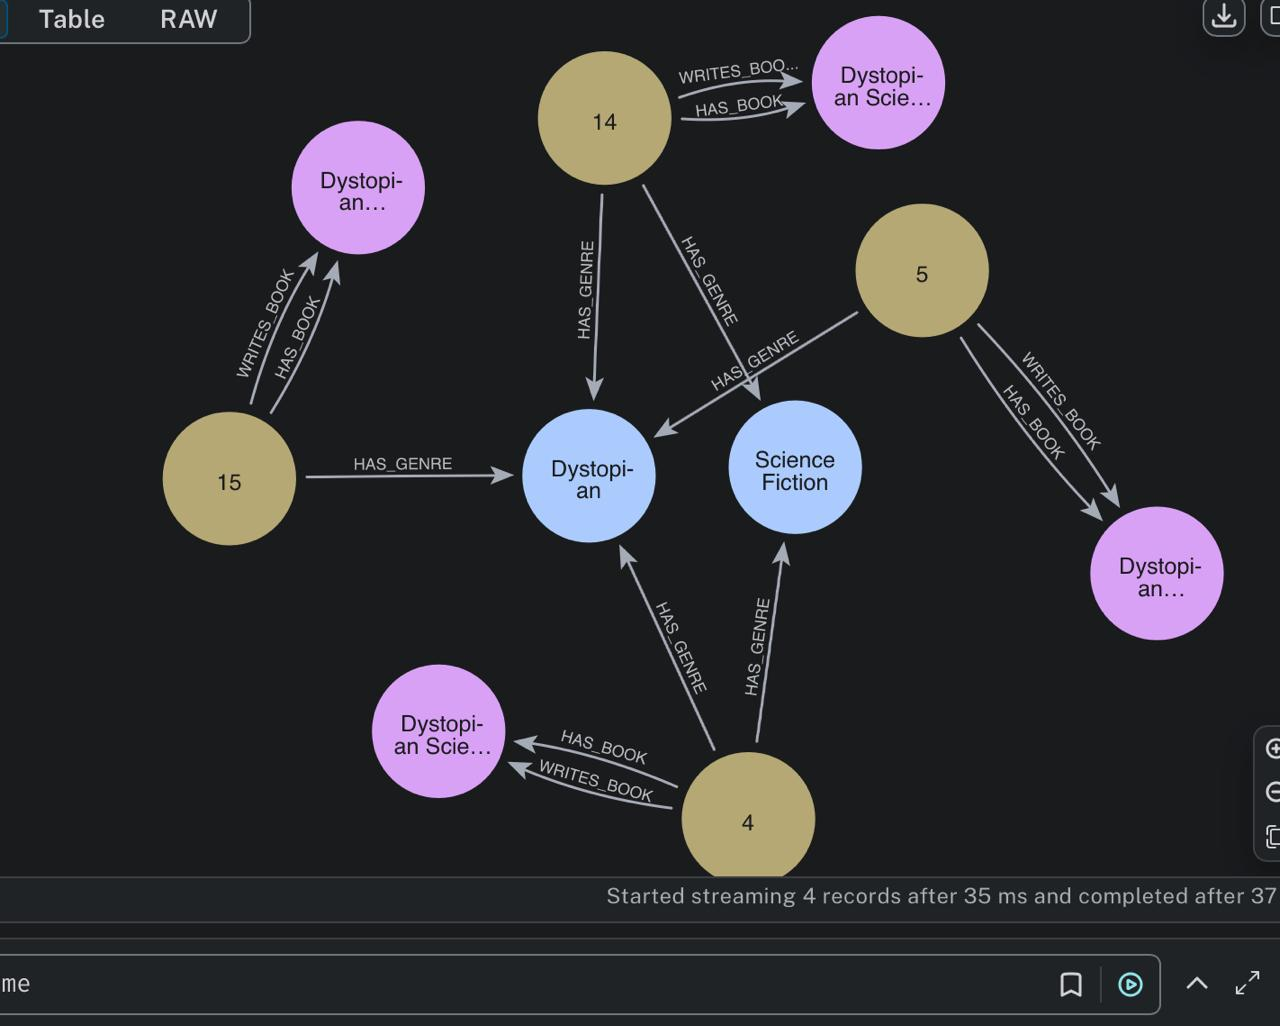

In [293]:
query = "Find the books that comes under the genre that has the label Dystopian"

cypher_query = """MATCH (g:Genre {label: 'Dystopian'})<-[:HAS_GENRE]-(bg:BookGenre)-[:HAS_BOOK]->(b:Book)
RETURN b"""

from IPython.display import Image
Image("./images/visualisation.jpeg",width=600, height=800)

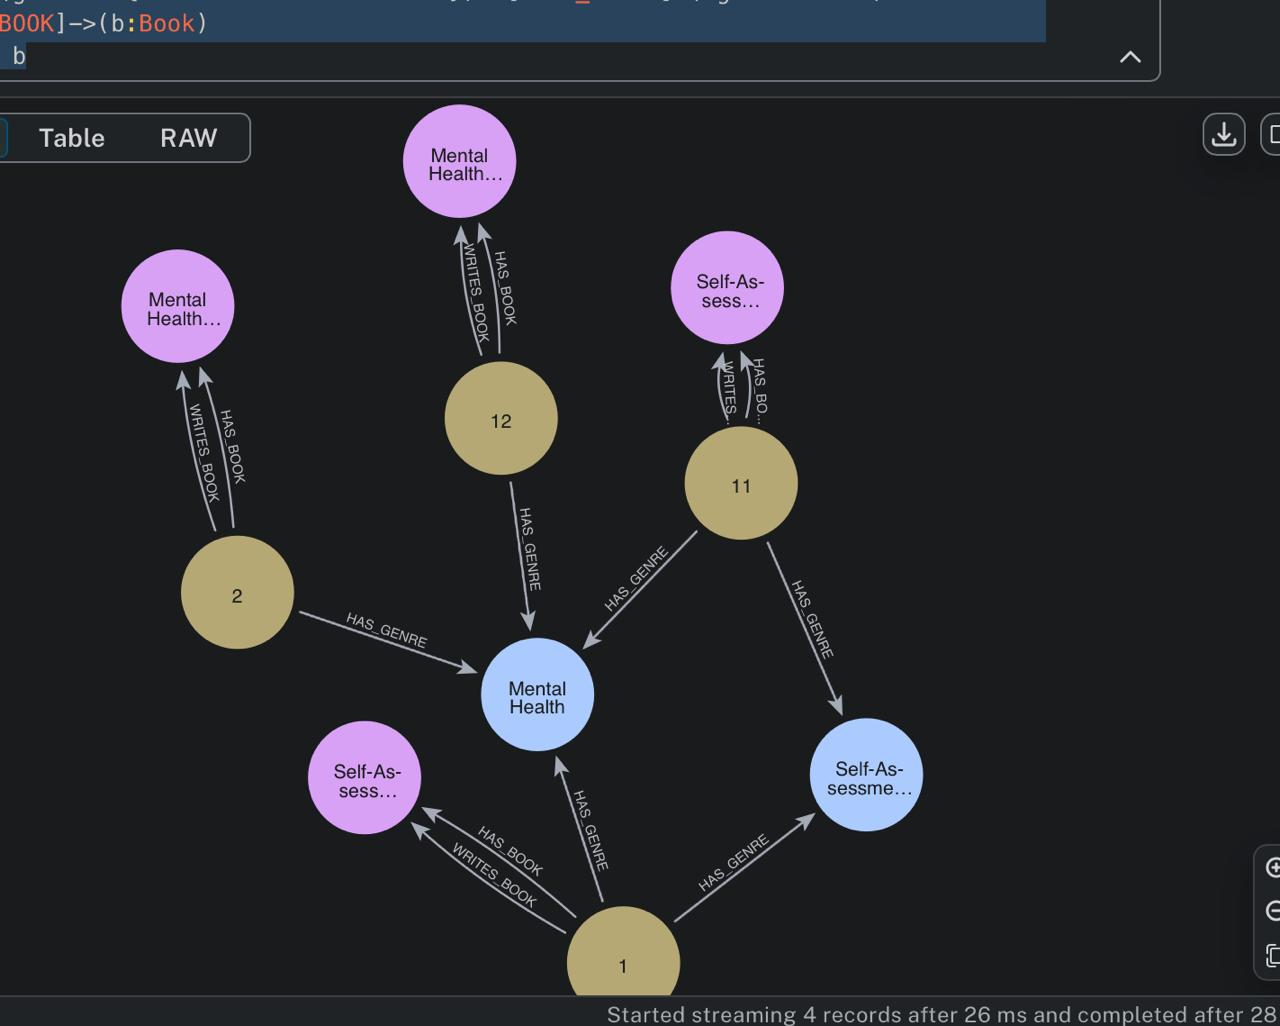

In [294]:
query = "Find books related to the genre Mental Health"

cypher_query = """
MATCH (g:Genre {label: 'Mental Health'})<-[:HAS_GENRE]-(bg:BookGenre)-[:HAS_BOOK]->(b:Book)
RETURN b
"""
from IPython.display import Image
Image("./images/visualisation2.jpeg",width=600, height=800)
